# First Order Time Delay Controller

In the Paper 'Design of Decoupled Controllers for MIMO Systems' by Aström, Johansson and Wang the Decoupling for small frequencies is described.

The following calculation is based on the First Order Time Delay (FOTD) Identification method, which results in a Two Input Two Output (TITO) System for the System in feedforward representation. 

To Decouple the system a Taylor Series around the steady state s=0 is used to derive Interaction from an input to another output. Since we approximate the system always with a FOTD Model, we can derive the interaction:

In [1]:
# Import the needed packages, SymPy
import sympy as sp
from sympy import init_printing
init_printing()

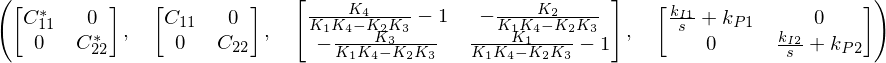

In [309]:
# Define the variables
# Complex variable
s = sp.symbols('s')
# FOTD Coeffficients
T1,T2,T3,T4 = sp.symbols('T_1 T_2 T_3 T_4')
K1,K2,K3,K4 = sp.symbols('K_1 K_2 K_3 K_4')
# Time Delay Coefficients
L1,L2,L3,L4 = sp.symbols('L_1 L_2 L_3 L_4')
# Controller variables for the diagonal controller for Q
C1D, C2D = sp.symbols('C_11^* C_22^*')
# Controller variables for the diagonal controller for G
C1, C2 = sp.symbols('C_11 C_22')
# Proportional Gain
kp1,kp2= sp.symbols('k_P1 k_P2')
# Integral Gain
ki1,ki2 = sp.symbols('k_I1 k_I2')

# Vectorize
TV = [T1,T2,T3,T4]
KV = [K1,K2,K3,K4]
LV = [L1,L2,L3,L4]
QV = [[C1D,0],[0,C2D]]
GV = [[C1,0],[0,C2]]
PV = [[kp1,0],[0,kp2]]
IV = [[ki1,0],[0,ki2]]


# Define a FOTD
def FOTD(K,T,L):
    return K/(T*s+1) * sp.exp(-L*s)

#Define a Matrix of FOTD
G = sp.zeros(2)
for i in range(0,4):
    G[i]= FOTD(KV[i],TV[i],LV[i])
    
#Define the diagonal controller in Q
KQ = sp.Matrix(QV)

#Define the diagonal controller in G
KG = sp.Matrix(GV)

# Define the Proportional and Integral Controller
KP = sp.Matrix(PV)
KI = sp.Matrix(IV)
PI = KP+KI*(1/s)
# Define the decoupler
D = G.subs(s,0)
D = sp.simplify(D**-1)

KQ,KG,S,PI

In [314]:
# Get the Controller solving for splitter
# D*KQ = (I+S)*KG, KG != KQ, => S = (D-I)
S = D-sp.eye(2)
# Get the Numerator of closed loop
H_N = sp.simplify(G*(sp.eye(2)+S))
# Get the Denominator of closed loop
H_D = sp.simplify(sp.eye(2)+G*PI)

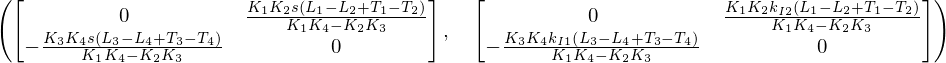

In [319]:
# Coupling c1,c2
c = [[0,sp.simplify(H_N[1].series(s,0,2).removeO())],[sp.simplify(H_N[2].series(s,0,2).removeO()),0]]
C = sp.Matrix(c)
# Maximal Gain
h12,h21 = sp.symbols('h12 h21')
HMAX = sp.Matrix([[0,h12],[h21,0]])
# Inequality
sp.solve(HMAX-C,KI)
C,C*KI/s

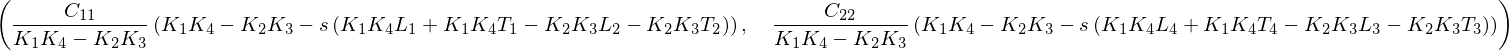

In [284]:
sp.simplify(H[0].series(s,0,2).removeO()), sp.simplify(H[3].series(s,0,2).removeO())

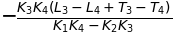

In [6]:
# Print the Interaction of Input 1 on Output 2 in small frequencies
k21

# Interpretation

We can see that the inverse of the determinant of the DCGain is a scaling factor describing the influence of the main diagonal elements in relation to the off diagonal elements. Hence, if the matrix is nearly equal in its gains the interaction is large.

The scaling is completed with the influence of the gains of the row affecting the output.

The results of the calculation give a direct interpretation:
Consider a TITO system described by FOTD functions. The Influence of the static decoupled system Q from an input i on an output j is neglectable iff:

- $T_i = T_j$ and $L_i = L_j$
- $T_i = L_j$ and $T_j = L_i$
- $K_i K_j \leq 1$ and $det(G_0) \geq 1$

# Decomposition of the Interaction

Since we want to directly apply the AMIGO procedure, we can state that:

$Q C^* = G D C = G C'$

Where $C'$ is the controller we would design from the regular system. Hence, we force the regular controller to behave like the ideal, decoupling controller.

$ D C = C'$

Or to get the decoupling controller as a function of the regular controller:

$C = D^{-1} C'$

In [7]:
# Define the symbols for interaction
k1,k2 = sp.symbols('k_1 k_2', real = True) 
c1,c2 = sp.symbols('c_1 c_2',real = True)
# Define symbols for the decoupling controller --> SMALL LETTER
ki1,ki2 = sp.symbols('k_{i1} k_{i2}',real = True)
kp1,kp2 = sp.symbols('k_{p1} k_{p2}',real = True)
b = sp.symbols('b',real = True)
# Define the symbols for the regular controller
KI1,KI2,KI3,KI4 = sp.symbols('K_{I1} K_{I2} K_{I3} K_{I4}',real = True)
KP1,KP2,KP3,KP4 = sp.symbols('K_{P1} K_{P2} K_{P3} K_{P4}',real = True)
B = sp.symbols('B',real = True)
# Vectorize
kV = [k1,k2]
cV = [c1,c2]
kiV = [ki1,ki2]
kpV = [kp1,kp2]
solvar =[ki1,ki2,kp1,kp2]
KIV = [KI1,KI2,KI3,KI4]
KPV = [KP1,KP2,KP3,KP4]

In [8]:
# Create a symbolic Controller
def PI(I,P,S):
    # Here S is setpointweight
    return P*S+I/s

# Create an decoupling controller -> Design Space Q
C_D = sp.diag(PI(ki1,kp1,1),PI(ki2,kp2,1))
# Create the regular controller -> Design Space G
C_R = sp.zeros(2)
for i in range(0,4):
    C_R[i]= PI(KIV[i],KPV[i],1)

C_RD = G.subs(s,0) * C_R

# Get substituion Rules -> make a list of equations
EQ = []
for i in range(0,4):
    EQ.append(C_D[i]- C_RD[i])

We now have a system of 4 Equations we can set to zero. We have to solve for four variables, the parameter of the decoupling controller, to get the desired connection from the heueristic rules for FOTD Systems to the more complex system.

We can divide these four equations into two Blocks:
- Block one, containing the decoupled controller, we can use to solve for the decoupling controller; 
  These are the entries of the main diagonal of both matrices.
- Block two, containing information about the ratio between the relation of the four controller;
  These are the entries of the minor diagonal of both matrices.

In [9]:
# Block one
# Solve for the decoupling controllers
kiEQ = [EQ[0],EQ[3]]
kisol = sp.solve(kiEQ,[C_D[0],C_D[3]],dict=True)

#Block two
# Solve for the ratio of the regular controllers
KEQ = [EQ[1],EQ[2]]
# Choose to substitute the minor diagonals -> solve for the other controllers
Ksol = sp.solve(KEQ,[C_R[1],C_R[2]], dict=True)
# Substitute the minor diagonals in the solution for ki
# We have a system of polynomials in s; Hence, we can get the right ratio by using coefficient comparision

# Regular controller
# First minor diagonal
a = C_R[1] # Chose controller from input 2 to output 1
expr = sp.simplify(Ksol[0][a]).expand()
# Get the coefficients corresponding to 1/s
I12 = expr.coeff('1/s');
# Get the coefficients corresponding to Proportional Gain
P12 = sp.simplify(expr-I12/s)

# Next controller
a = C_R[2]
expr = sp.simplify(Ksol[0][a]).expand()
# Get the coefficients corresponding to 1/s
I21= expr.coeff('1/s')
# Get the coefficients corresponding to Proportional Gain
P21 = sp.simplify(expr-I21/s)

We now have a relation between the choosen (main loop) controller and the other (coupling loop) controller, given by the following relationships:

In [10]:
Ksol[0]

We use this relationship to substitute the controller in the relationship for the decoupling controller.

In [11]:
# Decoupling Controller 1
# Set the key of the dictionary of solutions
a = C_D[0]
# Substitute the regular controllers in the current solutions
sub1 = kisol[0][a].subs(KPV[1],P12).subs(KPV[2],P21).subs(KIV[1],I12).subs(KIV[2],I21)
# Simplify the equation
sub1 = sp.simplify(sub1)

# Decoupling Controller 2
# Set the key of the dictionary of solutions
a = C_D[3]
# Substitute the regular controllers in the current solutions
sub2 = kisol[0][a].subs(KPV[1],P12).subs(KPV[2],P21).subs(KIV[1],I12).subs(KIV[2],I21)
# Simplify the equation
sub2 = sp.simplify(sub2)

We get the decoupled controller - original designed by using Q - as a function of the choosen (main loop) controller

In [12]:
# First Controller
sub1

In [13]:
# Second Controller
sub2

Use that knowledge to derive the proportional and integral gains of the controller by comparison of the coefficients:

In [1]:
# Decoupling controller 1 -> We can directly see the proportional and integral coeffcients
sp.simplify(sub1-sub1.coeff('1/s')/s),sp.simplify(sub1.coeff('1/s'))

NameError: name 'sp' is not defined

In [15]:
# Decoupling controller 2 -> We can directly see the proportional and integral coeffcients
sp.simplify(sub2-sub2.coeff('1/s')/s),sp.simplify(sub2.coeff('1/s'))

# Deriving the maximal coupling

In the paper a maximal permissible interaction is derived by the magnitude of the minor diagonal transfer functions:

$|h_{12}| \leq \kappa_1$ and $|h_{21}| \leq \kappa_2$. 

In the following, we will just focus on the first equation.

Substituing the closed loop transfer functions the equation becomes:

$\mid \frac{q_{12} c_2}{(1+q_{11}c_1)(1+q_{22}c_2)} \mid \leq \kappa_1$

We can now use the approximation for small frequencies $q_{12} \approx k_{12}s$, $c_2 = \frac{k_{I2}}{s} + k_{p2}~b$ and using the definition of the sensitivity $S = \frac{1}{1+G~C}$ we get:

$\mid k_{12}~(k_{I2}+b~k_{P2}) ~S_1 ~S_2 \mid \leq \kappa_1$

To get the worst case, substitute the maximum over all possible frequencies for the Sensitivity, the maximum Sensititvity $M_{Si} = \max_\limits{\omega} \mid S_i \mid$:

$\mid k_{12}~(k_{I2}+b~k_{P2}) \mid ~M_{S1} ~M_{S2}  \leq \kappa_1$

So we can derive the upper interaction due to the small frequency approximation and the robustness constrains given to be:

$\mid k_{12}~(k_{I2}+b~k_{P2}) \mid \leq \frac{\kappa_1}{ ~M_{S1} ~M_{S2}} = \gamma_1$

Using the knowledge from above we get:

In [40]:
# Get the upper limit of the interaction in terms of the original coeffients
gamma1 = sp.Abs(k12*s*sp.simplify(sub2.coeff('1/s')/s)+s*k12*b*(sp.simplify(sub2-sub2.coeff('1/s')/s)))
gamma1 = sp.simplify(gamma1)
gamma2 = sp.Abs(k21*s*sp.simplify(sub1.coeff('1/s')/s)+s*k21*b*sp.simplify(sub1-sub1.coeff('1/s')/s))
gamma2 = sp.simplify(sp.simplify(gamma2))

In [41]:
gamma1

In [42]:
gamma2

Hence the formulation for the maximal interaction in terms of the original transfer functions is given by:

$\gamma_1 = \mid K_2 \left( (T_1+L_1) - (T_2+L_2) \right) \left(K_{I4}+s~b~K_{P4}\right) \mid$

$\gamma_2 = \mid K_3 \left( (T_3+L_3) - (T_4+L_4) \right) \left(K_{I1}+s~b~K_{P1}\right) \mid$